# Importing Libs

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.util import view_as_blocks
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


In [2]:
directory_path = '/kaggle/input/satellite-image-and-mask/train_image'

# List all files in the directory
files = os.listdir(directory_path)

# Count only the files (excluding subdirectories)
file_count = sum([1 for f in files if os.path.isfile(os.path.join(directory_path, f))])

print(f'Number of files in the directory: {file_count}')

Number of files in the directory: 60


In [ ]:
train_image_path = "/kaggle/input/satellite-image-and-mask/train_image"
train_mask_path = "/kaggle/input/satellite-image-and-mask/train_mask"
class_dict_path = "/kaggle/input/satellite-image-and-mask/class_dict_seg.csv"

sample_image = cv2.imread(os.path.join(train_image_path, "/kaggle/input/satellite-image-and-mask/train_image/PHOTO-2023-04-08-11-41-13-2.jpg"))
sample_mask = cv2.imread(os.path.join(train_mask_path, "/kaggle/input/satellite-image-and-mask/train_mask/PHOTO-2023-04-08-11-41-13-2.png"), cv2.IMREAD_GRAYSCALE)


class_dict = pd.read_csv(class_dict_path)
class_colors = {tuple(map(int, row[1:4])): i for i, row in class_dict.iterrows()}


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title("Satellite Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap="gray")
plt.title("Mask")

plt.show()

In [6]:
patch_size = 256
IMG_SIZE = 256

# Exploratory Data Analysis EDA# 

In [8]:
def visualize_samples(num_samples=2):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    
    image_filenames = sorted(os.listdir(train_image_path))
    mask_filenames = sorted(os.listdir(train_mask_path))
    
    matched_pairs = []
    for img_name in image_filenames:
        base_name = os.path.splitext(img_name)[0]  
        corresponding_mask = base_name + ".png"  
        if corresponding_mask in mask_filenames:
            matched_pairs.append((img_name, corresponding_mask))
    
    matched_pairs = matched_pairs[:num_samples]
    
    for i, (img_name, mask_name) in enumerate(matched_pairs):
        image = cv2.imread(os.path.join(train_image_path, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(os.path.join(train_mask_path, mask_name), cv2.IMREAD_UNCHANGED)      # Load mask

        
        axes[i, 0].imshow(image)         # Plot image
        axes[i, 0].set_title("Satellite Image:")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask, cmap="gray")         # Plot mask
        axes[i, 1].set_title("Segmentation Mask:")
        axes[i, 1].axis("off")
    
    plt.show()


# Data Integrity

In [9]:
def check_data_integrity():
    images = sorted(os.listdir(train_image_path))
    masks = sorted(os.listdir(train_mask_path))
    image_names = [os.path.splitext(img)[0] for img in images]
    mask_names = [os.path.splitext(mask)[0] for mask in masks]
    
    missing_masks = [img for img in image_names if img not in mask_names]
    missing_images = [mask for mask in mask_names if mask not in image_names]
    print("Data Integrity")
    print(f"Missing Masks: {len(missing_masks)}")
    print(f"Missing Images: {len(missing_images)}")

# **Preprocess of images and mask**

In [10]:
IMG_SIZE = 256  

def preprocess_image(img):
    img = (img * 255).astype(np.uint8)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0  # Normalize again


def preprocess_mask(mask, class_colors):
    mask = mask.astype(np.uint8) 
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    mask_class = np.zeros(mask.shape[:2], dtype=np.uint8)
    for rgb, class_idx in class_colors.items():
        mask_class[(mask == rgb).all(axis=-1)] = class_idx  # Assign class index

    return mask_class


# Dataset Pipeline

In [11]:
def load_dataset():
    image_dataset = []
    mask_dataset = []
    patch_size = 256
    root_directory = '/kaggle/input/satellite-image-and-mask'
    image_directories = ['test_image', 'train_image']
    
    for image_directory in image_directories:
        image_directory_path = os.path.join(root_directory, image_directory)
        
        for dirpath, dirnames, filenames in os.walk(image_directory_path):
            filenames.sort()
            for filename in filenames:
                if filename.endswith(".jpg"):
                    image_path = os.path.join(dirpath, filename)
                    image = cv2.imread(image_path)
                    if image is not None:
                        height, width, _ = image.shape
                        new_height = (height // patch_size) * patch_size
                        new_width = (width // patch_size) * patch_size
                        image = image[:new_height, :new_width, :]
                        patches = view_as_blocks(image, (patch_size, patch_size, 3))
                        
                        for i in range(patches.shape[0]):
                            for j in range(patches.shape[1]):
                                single_patch_img = patches[i, j, :, :, :].copy() / 255  
                                image_dataset.append(single_patch_img)
    
    mask_root_directory = '/kaggle/input/satellite-image-and-mask'
    mask_directories = ['test_mask', 'train_mask']
    
    for mask_directory in mask_directories:
        mask_directory_path = os.path.join(mask_root_directory, mask_directory)
        
        for dirpath, dirnames, filenames in os.walk(mask_directory_path):
            filenames.sort()
            for filename in filenames:
                if filename.endswith(".png"):
                    mask_path = os.path.join(dirpath, filename)
                    mask = cv2.imread(mask_path)
                    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                    x_axis = (mask.shape[1] // patch_size) * patch_size
                    y_axis = (mask.shape[0] // patch_size) * patch_size
                    mask = Image.fromarray(mask)
                    mask = mask.crop((0, 0, x_axis, y_axis))
                    mask = np.array(mask)
                    patches_mask = view_as_blocks(mask, (patch_size, patch_size, 3))
                    patches_mask = patches_mask.reshape(-1, patch_size, patch_size, 3)
                    mask_dataset.extend(patches_mask)
    
    return np.array(image_dataset), np.array(mask_dataset)

In [12]:
def split_data(images, masks):
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

# Main

Data Integrity
Missing Masks: 0
Missing Images: 0


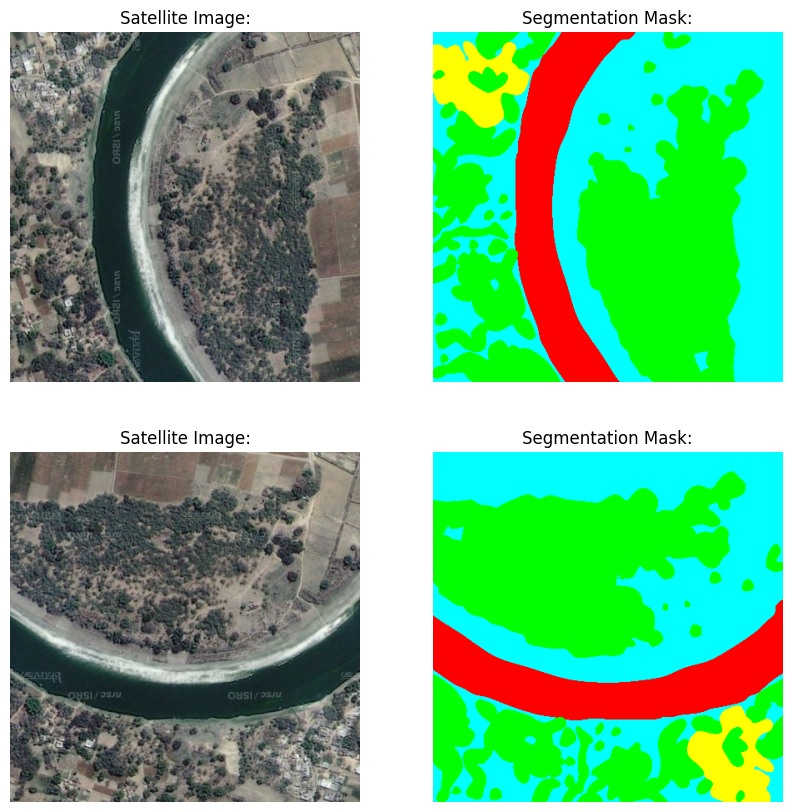

Loaded 74 images and 74 masks.
Train Size: 59, Validation Size: 15


In [16]:
images, masks = load_dataset()
check_data_integrity()

visualize_samples()


processed_images = np.array([preprocess_image(img) for img in images])
processed_masks = np.array([preprocess_mask(mask, class_colors) for mask in masks])
print(f"Loaded {len(images)} images and {len(masks)} masks.")
X_train, X_val, y_train, y_val = split_data(images, masks)
print(f"Train Size: {len(X_train)}, Validation Size: {len(X_val)}")

# One - Hot Encoding of Masks

In [17]:
def one_hot_encode_mask(mask, num_classes):
    return to_categorical(mask, num_classes)

num_classes = len(class_colors) 
one_hot_masks = np.array([one_hot_encode_mask(mask, num_classes) for mask in processed_masks])

one_hot_masks = one_hot_masks.reshape(-1, patch_size, patch_size, num_classes)

print(f"One-hot encoded mask shape: {one_hot_masks.shape}")

One-hot encoded mask shape: (74, 256, 256, 5)


1. a - Number of images (batch size or dataset size).
2. b - Height of each mask.
3. c - Width of each mask.
4. d - Number of classes (each pixel belongs to one of 6 possible categories).1. 

**one hot encoding is needed for categorical cross-entropy loss in deep learning**

# Training Statistics

In [13]:
def plot_training_curves(history):
    """Plot training and validation loss & accuracy"""
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Model Building

In [17]:
def build_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)

    # Decoder
    up4 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(conv3)
    concat4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(concat4)
    conv4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv4)

    up5 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(conv4)
    concat5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(concat5)
    conv5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(conv5)

    model = models.Model(inputs, outputs)
    return model

input_shape = (patch_size, patch_size, 3)  # Input size
model = build_unet(input_shape, num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        295,040 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 64)   │         73,792 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 128)  │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │         73,792 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 2,067,909 (7.89 MB)

 Trainable params: 2,067,909 (7.89 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print(f"Total images: {len(images)}")
print(f"Total masks: {len(one_hot_masks)}")

Total images: 74
Total masks: 74


In [19]:
print(f"X_train shape: {X_train.shape}")
print(f"one_hot_masks shape: {one_hot_masks.shape}")

X_train shape: (59, 1, 256, 256, 3)
one_hot_masks shape: (74, 256, 256, 5)


In [18]:
X_train, X_val, y_train, y_val = train_test_split(images, one_hot_masks, test_size=0.2, random_state=42)
print(f"Training images: {len(X_train)}")
print(f"Training masks: {len(y_train)}")
print(f"Validation images: {len(X_val)}")
print(f"Validation masks: {len(y_val)}")

Training images: 59
Training masks: 59
Validation images: 15
Validation masks: 15


In [19]:
X_train = np.squeeze(X_train, axis=1)
X_val = np.squeeze(X_val, axis=1)

In [16]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=8)

model.save("land_cover_unet.h5")

plot_training_curves(history)

NameError: name 'model' is not defined

In [20]:
#to import the trained model
model = load_model("/kaggle/input/land_cover_unet/tensorflow2/default/1/land_cover_unet.h5")

In [17]:
model = load_model("land_cover_unet.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'land_cover_unet.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [28]:
import joblib

In [29]:
joblib.dump(model, "land_cover_unet.h5")

['land_cover_unet.h5']

In [21]:
#model = load_model("land_cover_unet.h5")

loss, acc = model.evaluate(X_val, y_val)
print(f"Restored model accuracy: {acc:.4f}")

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8003 - loss: 0.5677
Restored model accuracy: 0.8003
Validation Loss: 0.5677
Validation Accuracy: 0.8003



Evaluating with IoU metric:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Mean IoU: 0.3811

Class-wise IoU:
Water: 0.0297
Vegetation: 0.7470
Urban: 0.3353
Bare Soil: 0.7937
Forest: 0.0000


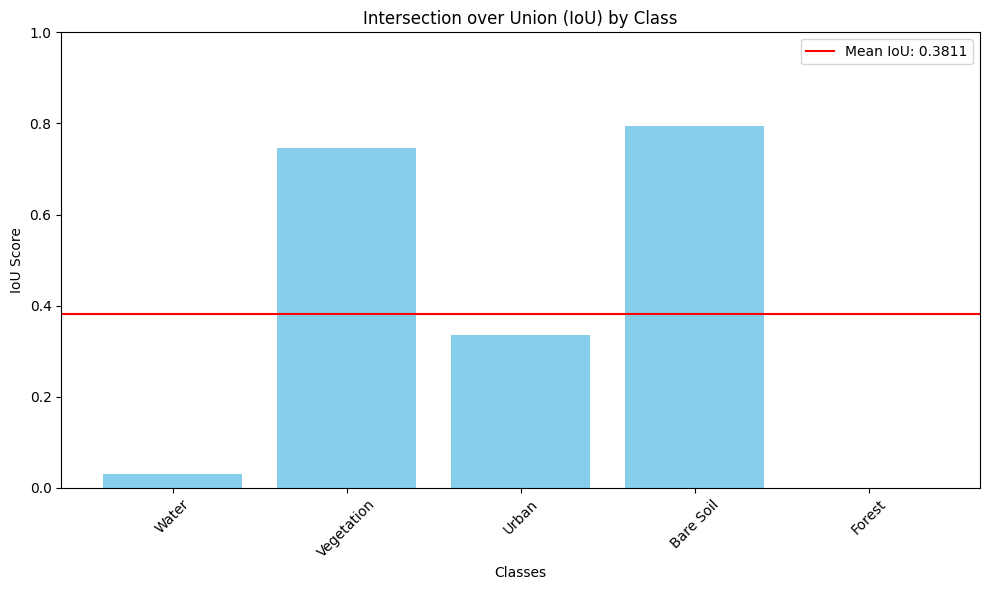

In [24]:
def calculate_iou(y_true, y_pred):
    """
    Calculate the Intersection over Union (IoU) for each class and mean IoU across all classes.
    
    Parameters:
    -----------
    y_true : numpy array
        Ground truth segmentation masks (one-hot encoded or class indices)
    y_pred : numpy array
        Predicted segmentation masks (one-hot encoded or class indices)
    
    Returns:
    --------
    class_ious : dict
        Dictionary containing IoU for each class
    mean_iou : float
        Mean IoU across all classes
    """
    # Ensure the inputs are in class indices format (not one-hot encoded)
    if len(y_true.shape) == 4:  # If one-hot encoded
        y_true = np.argmax(y_true, axis=-1)
    if len(y_pred.shape) == 4:  # If one-hot encoded
        y_pred = np.argmax(y_pred, axis=-1)
    
    # Get the number of classes from the masks
    num_classes = len(np.unique(y_true))
    
    # Initialize IoU dict for each class
    class_ious = {}
    
    # Calculate IoU for each class
    for class_id in range(num_classes):
        # Create binary masks for the current class
        y_true_class = (y_true == class_id).flatten()
        y_pred_class = (y_pred == class_id).flatten()
        
        # Calculate intersection and union
        intersection = np.logical_and(y_true_class, y_pred_class).sum()
        union = np.logical_or(y_true_class, y_pred_class).sum()
        
        # Calculate IoU, handling division by zero
        iou = intersection / union if union > 0 else 0.0
        
        # Map class_id to terrain label
        terrain_labels = {
            0: "Water",
            1: "Vegetation",
            2: "Urban",
            3: "Bare Soil",
            4: "Forest",
        }
        
        class_name = terrain_labels.get(class_id, f"Class {class_id}")
        class_ious[class_name] = iou
    
    # Calculate mean IoU
    mean_iou = sum(class_ious.values()) / len(class_ious)
    
    return class_ious, mean_iou

# Example usage:
def evaluate_model_with_iou(model, X_val, y_val):
    """
    Evaluate model performance using IoU metric.
    
    Parameters:
    -----------
    model : Keras model
        Trained segmentation model
    X_val : numpy array
        Validation images
    y_val : numpy array
        Validation masks (ground truth)
    
    Returns:
    --------
    None (prints results)
    """
    # Get model predictions
    y_pred = model.predict(X_val)
    
    # Calculate IoU metrics
    class_ious, mean_iou = calculate_iou(y_val, y_pred)
    
    # Print results
    print(f"Mean IoU: {mean_iou:.4f}")
    print("\nClass-wise IoU:")
    for class_name, iou in class_ious.items():
        print(f"{class_name}: {iou:.4f}")
    
    # Create a bar chart of class IoUs
    plt.figure(figsize=(10, 6))
    classes = list(class_ious.keys())
    ious = list(class_ious.values())
    
    plt.bar(classes, ious, color='skyblue')
    plt.axhline(y=mean_iou, color='r', linestyle='-', label=f'Mean IoU: {mean_iou:.4f}')
    
    plt.xlabel('Classes')
    plt.ylabel('IoU Score')
    plt.title('Intersection over Union (IoU) by Class')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# To use this in your existing code:
# After training your model and validating with accuracy
print("\nEvaluating with IoU metric:")
evaluate_model_with_iou(model, X_val, y_val)

# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


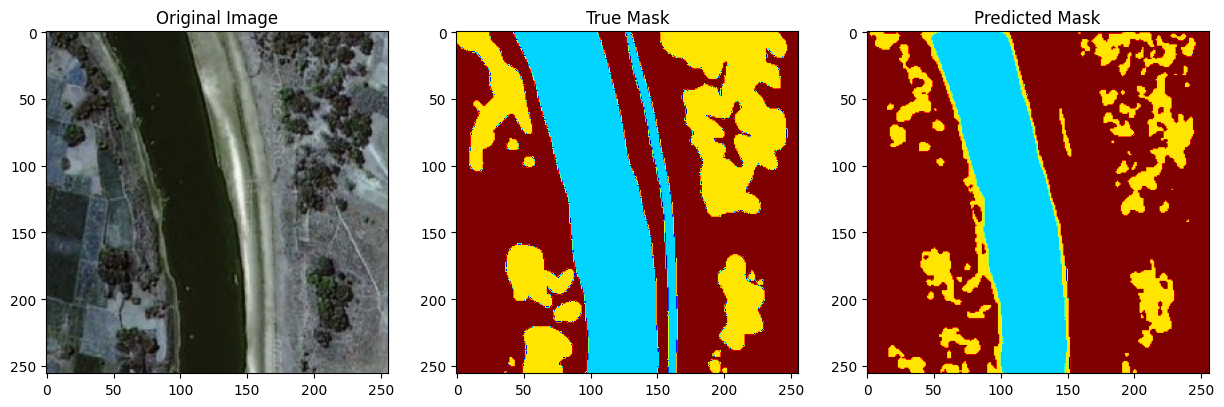

In [27]:
def predict_and_visualize(model, X_sample, y_true):
    y_pred = model.predict(X_sample)
    y_pred = np.argmax(y_pred, axis=-1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(X_sample[0])
    axes[0].set_title("Original Image")
    
    axes[1].imshow(np.argmax(y_true[0], axis=-1), cmap="jet")
    axes[1].set_title("True Mask")

    axes[2].imshow(y_pred[0], cmap="jet")
    axes[2].set_title("Predicted Mask")

    plt.show()

# Testing on a sample image
predict_and_visualize(model, X_val[2:], y_val[2:])


# Visualize Prediction

In [33]:
class_colors

{(0, 255, 255): 0,
 (0, 0, 255): 1,
 (0, 255, 0): 2,
 (255, 255, 0): 3,
 (255, 0, 255): 4}

In [ ]:
'''
{(0, 255, 255): 0 🩵,
 (0, 0, 255): 1 🔵,
 (0, 255, 0): 2 🟢,
 (255, 255, 0): 3 🟡,
 (255, 0, 255): 4} 🩷

'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Detected Terrain Types in Image:
Water, Urban, Bare Soil


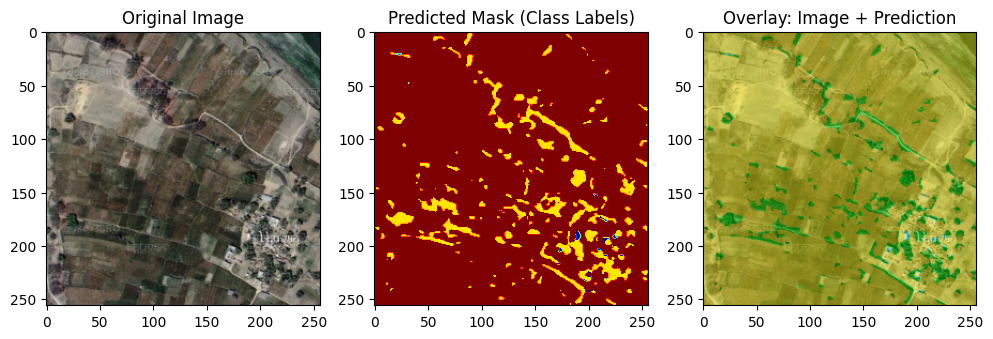

In [26]:
def classify_and_visualize_prediction(image_path, model):
    """Predicts the mask, classifies terrain, and visualizes the result"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (256, 256)) / 255.0

    predicted_mask = model.predict(np.expand_dims(image_resized, axis=0))
    predicted_classes = np.argmax(predicted_mask.squeeze(), axis=-1)  # Convert to class indices

    color_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for color, label in class_colors.items():
        color_mask[predicted_classes == label] = color  # Assign colors based on class label

    overlay = cv2.addWeighted(image_resized, 0.6, color_mask / 255.0, 0.4, 0)

    unique_classes = np.unique(predicted_classes)
    detected_terrains = [terrain_labels[label] for label in unique_classes if label in terrain_labels]

    print("Detected Terrain Types in Image:")
    print(", ".join(detected_terrains))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_resized)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_classes, cmap="jet")
    plt.title("Predicted Mask (Class Labels)")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay: Image + Prediction")

    plt.show()

terrain_labels = {
    0: "Water",
    1: "Vegetation",
    2: "Urban",
    3: "Bare Soil",
    4: "Forest",
}

classify_and_visualize_prediction("/kaggle/input/satellite-image-and-mask/test_image/Test_1.jpg", model)


1.Change the one hot enc method
2. Change epoch values and no. of layers
3.compare the metrics
4.